In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
pd.options.display.float_format = '{:.4f}'.format

In [3]:
kickstarter = pd.read_csv('./ks-projects-201801.csv')

In [4]:
kickstarter.shape

(378661, 15)

In [5]:
kickstarter.dtypes

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

In [6]:
kickstarter.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0000,2015-08-11 12:12:28,0.0000,failed,0,GB,0.0000,0.0000,1533.9500
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0000,2017-09-02 04:43:57,2421.0000,failed,15,US,100.0000,2421.0000,30000.0000
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0000,2013-01-12 00:20:50,220.0000,failed,3,US,220.0000,220.0000,45000.0000
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0000,2012-03-17 03:24:11,1.0000,failed,1,US,1.0000,1.0000,5000.0000
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0000,2015-07-04 08:35:03,1283.0000,canceled,14,US,1283.0000,1283.0000,19500.0000


In [7]:
kickstarter.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,378661.0000,378661.0000,378661.0000,378661.0000,374864.0000,378661.0000,378661.0000
mean,1074731191.9888,49080.7915,9682.9793,105.6175,7036.7289,9058.9241,45454.4015
std,619086204.3226,1183391.2591,95636.0100,907.1850,78639.7453,90973.3431,1152950.0551
min,5971.0000,0.0100,0.0000,0.0000,0.0000,0.0000,0.0100
25%,538263516.0000,2000.0000,30.0000,2.0000,16.9800,31.0000,2000.0000
50%,1075275634.0000,5200.0000,620.0000,12.0000,394.7200,624.3300,5500.0000
75%,1610148624.0000,16000.0000,4076.0000,56.0000,3034.0900,4050.0000,15500.0000
max,2147476221.0000,100000000.0000,20338986.2700,219382.0000,20338986.2700,20338986.2700,166361390.7100


We can see which columns don't contain useful information for our predictions:

- The ID column contains a unique identifier for each row and will not be useful for prediction
- The name column also contains a unique identifier. Since our analysis is currently a quantitative one, we will not be using the information in this column. We might be interested in the information in this column if we were to perform natural language processing on the names.
- The category column contains highly detailed classification information. To use this information, we will need to generate dummy variables from this column. We might be creating too many dummy variables by using this column. Our goal is not to create an overcomplicated model. Therefore, we will most likely not be using the information in this column (unless our model proves to be very inaccurate without this information).
- There are multiple columns containing information about the total amount pledged. These columns may prove to be highly correlated. Therefore, we should probably only keep one.
- There seems to be a close relationship between country and currency. We should consider dropping one of those columns as well.

The date columns (launched and deadline) will be transformed into a column measuring the length of the campaign in days.

The backers and goal columns are highly skewed. We will evaluate whether we should drop the outliers in these columns or keep them.

In [9]:
kickstarter.state.value_counts(normalize = True)

failed       0.5222
successful   0.3538
canceled     0.1024
undefined    0.0094
live         0.0074
suspended    0.0049
Name: state, dtype: float64

It seems that about 52% of projects while about 35% have succeeded. The rest have classifications that really aren't relevant for our analysis. Therefore, we should remove these rows from our data.

In [10]:
kickstarter_classify = kickstarter[kickstarter.state.isin(['failed', 'successful'])]
kickstarter_classify.state.value_counts(normalize=True)

failed       0.5961
successful   0.4039
Name: state, dtype: float64

Now we have a split of about 40% successful and 60% failed projects. Note that we assigned the filtered data to a new variable. It is always good practice to keep the old data around and assign transformed data to a new variable while performing exploratory data analysis. This reduces the chance of losing previous iterations of our data in case we make a mistake in our code.

Next we look at the main_category column. We use the value_counts function to evaluate how many projects are in each category.

In [11]:
kickstarter_classify.main_category.value_counts()

Film & Video    56527
Music           45949
Publishing      35445
Games           28521
Technology      27050
Art             25641
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64

We can use the crosstab function to see how successful projects are in each category.

In [12]:
pd.crosstab(kickstarter_classify.main_category,kickstarter_classify.state)

state,failed,successful
main_category,,
Art,14131,11510
Comics,4036,5842
Crafts,5703,2115
Dance,1235,2338
Design,14814,10550
Fashion,14182,5593
Film & Video,32904,23623
Food,15969,6085
Games,16003,12518


Add the success rate for each category

In [13]:
category_crosstab = pd.crosstab(kickstarter_classify.main_category,kickstarter_classify.state)
category_crosstab['success_rate'] = category_crosstab.successful/(category_crosstab.successful+category_crosstab.failed)
category_crosstab

state,failed,successful,success_rate
main_category,,,
Art,14131,11510,0.4489
Comics,4036,5842,0.5914
Crafts,5703,2115,0.2705
Dance,1235,2338,0.6544
Design,14814,10550,0.4159
Fashion,14182,5593,0.2828
Film & Video,32904,23623,0.4179
Food,15969,6085,0.2759
Games,16003,12518,0.4389


Comics, music, and dance seem to be the only 3 categories where there are more successful than failed projects. While Film & Video has a success rate lower than 0.5 despite being the most popular category.

Now we will explore the currency variable.

In [14]:
kickstarter_classify.currency.value_counts()

USD    261511
GBP     29476
EUR     14378
CAD     12375
AUD      6621
SEK      1510
MXN      1411
NZD      1274
DKK       929
CHF       652
NOK       584
HKD       477
SGD       454
JPY        23
Name: currency, dtype: int64

The most popular currency is USD

In [15]:
currency_crosstab = pd.crosstab(kickstarter_classify.currency,kickstarter_classify.state)
currency_crosstab['success_rate'] = currency_crosstab.successful/(currency_crosstab.successful+currency_crosstab.failed)
currency_crosstab

state,failed,successful,success_rate
currency,,,
AUD,4610,2011,0.3037
CAD,8238,4137,0.3343
CHF,465,187,0.2868
DKK,567,362,0.3897
EUR,10496,3882,0.2700
GBP,17395,12081,0.4099
HKD,261,216,0.4528
JPY,16,7,0.3043
MXN,1015,396,0.2807


It seems that none of the currencies seem to break the 50% success rate. However, it looks like it does make a difference which currency you use since some are more successful than others.

# Visualizing the Data
It would be useful to see the distribution of project length for both successful and failed projects. To do this, we will transform the variable and then plot a side-by-side histogram.

First, we will transform the variable. Currently the date variables are stored as text. We saw this in the output of the dtypes function. Therefore, the first step in finding the project duration is to convert both columns to a datetime type. After this conversion, we will find the difference between the columns, round it to days, and then assign this data to a new column.

In [25]:
kickstarter_classify['launched_date'] = pd.to_datetime(kickstarter_classify.launched)
kickstarter_classify['deadline_date'] = pd.to_datetime(kickstarter_classify.deadline)
kickstarter_classify['duration'] = (kickstarter_classify.deadline_date - kickstarter_classify.launched_date).dt.days
kickstarter_classify.head()

/Users/anielkaaslan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/anielkaaslan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/anielkaaslan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,launched_date,deadline_date,duration
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0000,2015-08-11 12:12:28,0.0000,failed,0,GB,0.0000,0.0000,1533.9500,2015-08-11 12:12:28,2015-10-09,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0000,2017-09-02 04:43:57,2421.0000,failed,15,US,100.0000,2421.0000,30000.0000,2017-09-02 04:43:57,2017-11-01,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0000,2013-01-12 00:20:50,220.0000,failed,3,US,220.0000,220.0000,45000.0000,2013-01-12 00:20:50,2013-02-26,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0000,2012-03-17 03:24:11,1.0000,failed,1,US,1.0000,1.0000,5000.0000,2012-03-17 03:24:11,2012-04-16,29
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0000,2016-02-26 13:38:27,52375.0000,successful,224,US,52375.0000,52375.0000,50000.0000,2016-02-26 13:38:27,2016-04-01,34


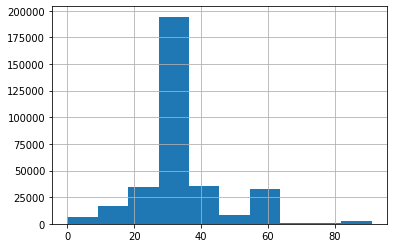

In [26]:
kickstarter_classify.duration.hist()

The majority of projects last around a month.

Let's plot the successful and failed projects side by side to see if their distributions differ.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10d1f7198>,
      dtype=object)

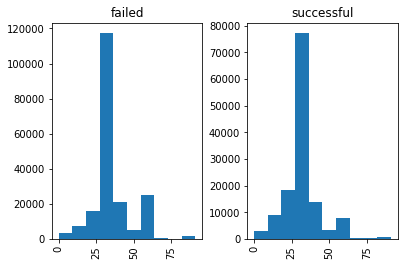

In [19]:
kickstarter_classify.duration.hist(by=kickstarter_classify.state)

The majority of both failed and successful projects last about a month.

Next up is the goal in real US Dollar.

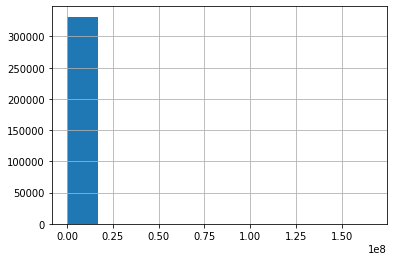

In [20]:
kickstarter_classify.usd_goal_real.hist()

It seems like there is an outlier that is preventing us to see the distribution.

Perhaps if we increase the number of bins, this should give us a better picture of the distribution.

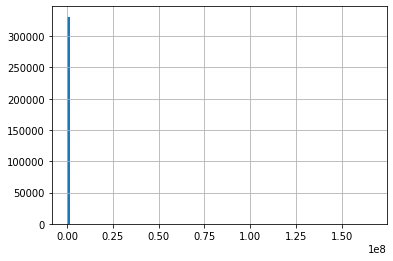

In [22]:
kickstarter_classify.usd_goal_real.hist(bins=100)

It looks like this still isn't enough to give us a more granular view of the distribution.

Let's try to evaluate how many outliers there are and whether they are intentional or perhaps they should be removed.

First, let's look at the largest value.

In [23]:
max(kickstarter_classify.usd_goal_real)
166361390.71

166361390.71

The max value is about $166 million dollars.

Let's look at the projects asking for more than a million dollars in real USD goal.

In [24]:
kickstarter_classify[kickstarter_classify.usd_goal_real > 1000000]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,launched_date,deadline_date,duration
340,1001542282,You in a novel,Publishing,Publishing,EUR,2015-11-09,1000000.0000,2015-09-10 23:03:21,10.0000,failed,1,IT,11.1800,10.7600,1076403.0900,2015-09-10 23:03:21,2015-11-09,59
971,1004941506,Maori MBT Awareness Centre,Web,Journalism,CAD,2017-10-18,2000000.0000,2017-08-19 22:13:55,2242.0000,failed,19,CA,1160.6700,1794.4600,1600768.3700,2017-08-19 22:13:55,2017-10-18,59
1042,1005237669,The Old Soul of a Lion,Film & Video,Film & Video,USD,2014-10-14,3000000.0000,2014-08-15 20:16:22,4.0000,failed,2,US,4.0000,4.0000,3000000.0000,2014-08-15 20:16:22,2014-10-14,59
1144,1005820080,The Million Pound Shirt,Fashion,Fashion,GBP,2015-11-25,1000000.0000,2015-10-21 22:00:04,10.0000,failed,1,GB,15.4700,15.0500,1505185.3600,2015-10-21 22:00:04,2015-11-25,34
1795,1009207145,** GOLIATH **,Product Design,Design,CAD,2014-07-21,3850000.0000,2014-06-21 22:34:21,285.0000,failed,5,CA,263.4100,264.6700,3575408.6200,2014-06-21 22:34:21,2014-07-21,29
2920,1015071175,Thermal Safe,Product Design,Design,USD,2015-06-10,2000000.0000,2015-04-22 03:54:47,665.0000,failed,8,US,665.0000,665.0000,2000000.0000,2015-04-22 03:54:47,2015-06-10,48
2993,1015466274,Genesis,Film & Video,Film & Video,EUR,2015-09-01,5000000.0000,2015-07-07 21:14:52,0.0000,failed,0,IT,0.0000,0.0000,5568982.9900,2015-07-07 21:14:52,2015-09-01,55
3140,1016210580,INDIRA – THE FIRST INDIAN GRAND MUSICAL,Musical,Theater,EUR,2016-04-27,15000000.0000,2016-02-27 13:08:01,15.0000,failed,6,ES,16.5900,17.1000,17104542.9700,2016-02-27 13:08:01,2016-04-27,59
3271,1016899157,Musée du cirque Gilles MAIGNANT : NICE CIRCUS ...,Performance Art,Art,EUR,2015-10-25,1000000.0000,2015-08-26 19:38:53,100.0000,failed,1,FR,115.3400,110.1700,1101697.7200,2015-08-26 19:38:53,2015-10-25,59
3293,1017011422,Electric Car,Technology,Technology,MXN,2017-09-13,40000000.0000,2017-08-19 01:19:23,510.0000,failed,2,MX,0.0000,28.8700,2263980.0800,2017-08-19 01:19:23,2017-09-13,24


These seem to be legitimate projects.

Let's look at the success breakdown:

In [27]:
kickstarter_classify[kickstarter_classify.usd_goal_real > 1000000].state.value_counts()

failed        829
successful     11
Name: state, dtype: int64

Only 11 projects of the 840 projects asking for more than a million dollars were successful. Since the data seems legitimate and not erroneously entered, we will keep these rows in the dataset.

The next step is to look at the correlation between the numeric variables to determine that there are no highly correlated variables.

In [28]:
kickstarter_classify.corr()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,duration
ID,1.0000,0.0019,0.0009,0.0008,-0.0003,0.0003,0.0018,0.0028
goal,0.0019,1.0000,0.0080,0.0048,0.0064,0.0060,0.9526,0.0227
pledged,0.0009,0.0080,1.0000,0.7173,0.8580,0.9536,0.0057,0.0081
backers,0.0008,0.0048,0.7173,1.0000,0.6975,0.7523,0.0052,-0.0000
usd pledged,-0.0003,0.0064,0.8580,0.6975,1.0000,0.9077,0.0070,0.0077
usd_pledged_real,0.0003,0.0060,0.9536,0.7523,0.9077,1.0000,0.0064,0.0087
usd_goal_real,0.0018,0.9526,0.0057,0.0052,0.0070,0.0064,1.0000,0.0216
duration,0.0028,0.0227,0.0081,-0.0000,0.0077,0.0087,0.0216,1.0000


The most correlated variables are USD pledged and USD pledged real and goal and USD goal real. Pledged and backers are moderately correlated with a correlation of 0.7173. Since the more backers we have, the more pledged money we have, we are better off removing that variable as well.

Before creating our model, we should ensure that there is no missing data. Some models will not produce a meaningful result with missing data. If there is a significant amount of missing data, then we should come up with a meaningful strategy to address the missing data.

In [29]:
kickstarter_classify.isnull().sum(axis = 0)

ID                    0
name                  3
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         210
usd_pledged_real      0
usd_goal_real         0
launched_date         0
deadline_date         0
duration              0
dtype: int64

The only variable containing missing data is the amount of pledged dollars. This confirms that we should remove this column.

# Preparing the Data
At this point we will start to prepare the data for applying ML algorithms to the data.

The first step is to pick only the columns that we decided to keep as well as separating the data to predictor (x) and response (y) variables. We use the get dummies function on the response variables to convert them from categorical values to a variable containing zeros and ones. We use the drop_first option to ensure that we only get one column (since for n values, the drop_first option will create n-1 variable)

In [30]:
kickstarter_variables = kickstarter_classify[['usd_goal_real', 'backers', 'main_category', 'duration', 'currency']]
kickstarter_y = pd.get_dummies(data=kickstarter_classify['state'], drop_first=True)

Convert the categorical variables to dummy variables using the get_dummies function.

In [31]:
kickstarter_x = pd.get_dummies(data=kickstarter_variables, columns=['main_category', 'currency'], drop_first=True)
kickstarter_x.head()

,usd_goal_real,backers,duration,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,1533.9500,0,58,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,30000.0000,15,59,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,45000.0000,3,44,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,5000.0000,1,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,50000.0000,224,34,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


Using the head function shows us that we have increased the number of columns from the 5 that we initially selected to 30 columns total.

The final step in the processing phase is to separate the data into test and train datasets. We do this to ensure that our model performs well even on the data that was not used for training. This is how we reduce overfitting. We randomly select 80% of the data for the training dataset and the remaining 20% is used for the test dataset.

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(kickstarter_x, kickstarter_y, test_size=0.2)

# Creating the Model
Since this is a classification problem, there are a number of algorithms at our disposal. Logistic regression is a good choice for our problem. Another good choice is random forest. SVM is also a suitable option for this type of problem. However, due to how SVM is implemented in scikit-learn, it is not recommended to use this algorithm on data with more than 10000 rows. Therefore, we will avoid using this algorithm for now, even though it is otherwise a good choice for this type of problem.

## Logistic Regression
First we generate our model and then we will proceed to evaluate it.

In [33]:
from sklearn.linear_model import LogisticRegression

ks_model = LogisticRegression().fit(X_train, y_train)


/Users/anielkaaslan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anielkaaslan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


One way to evaluate the model is using a confusion matrix. The confusion matrix specifies how many observations were correctly classified and how many were incorrectly classified.

In [35]:
from sklearn.metrics import confusion_matrix

y_pred_test = ks_model.predict(X_test)
confusion_matrix(y_test, y_pred_test)


array([[37779,  1790],
       [ 4743, 22023]])

The first entry in our matrix is the number of observations correctly classified as 0 (or failure). The second entry in the matrix are all entries incorrectly classified as 1 (or success). These observations are actually zeros but our algorithm classified them as 1. The third entry contains the count of all observations incorrectly classified as zero (or failure). The last entry contains the count of observations correctly classified as 1. Our goal is to maximize the first and last entries (the correctly classified observations) and minimize the incorrectly classified information. As we can see, out of 66335 observations, 60048 (or 90.5%) are correctly classified.

We have previously looked at the ROC curve. Recall that this curve is a measure of describing how well our algorithm classifies the data. The better our classification algorithm, the larger the area under the curve (also known as AUC=Area Under the Curve).

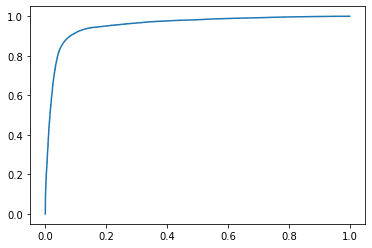

In [36]:
from sklearn import metrics

y_pred_proba = ks_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr)

In [37]:
auc

0.9556715525841152

The area under the curve is over 0.95. This is a decent number, but perhaps we could do better with a different algorithm

# Random Forest
Random forest is an ensemble algorithm. This means that it resamples the data multiple times and generates a decision tree from each sample. We then think of the trees as a group of algorithms. We base our decision on the outcome of the majority of algorithms in the ensemble.

In [38]:
from sklearn.ensemble import RandomForestClassifier

ks_rf = RandomForestClassifier().fit(X_train, y_train)

/Users/anielkaaslan/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/anielkaaslan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Here is our confusion matrix:

In [39]:
y_pred_test_rf = ks_rf.predict(X_test)
confusion_matrix(y_test, y_pred_test_rf)


array([[36965,  2604],
       [ 2849, 23917]])

Let's plot the ROC curve for the random forest that we have generated.

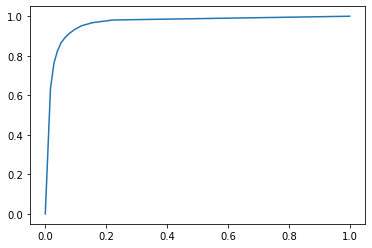

In [40]:
y_pred_proba_rf = ks_rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_rf)
auc = metrics.roc_auc_score(y_test, y_pred_proba_rf)

plt.plot(fpr,tpr)

In [41]:
auc

0.9647419562690026

While our AUC was already high, we have improved the score using the random forest algorithm.